In [88]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.image import imread
import math
from numpy import genfromtxt

from tensorflow.keras.models import load_model,model_from_json
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

# Model reconstruction from JSON file
with open('model.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('CNN_Model.h5')
model.compile(loss="mse", optimizer="adam")
with h5py.File('CNN_Model.h5','r') as hdf:
    layer_1_data = np.array(hdf.get('layer_1/layer_1/kernel:0'))
    layer_2_data = np.array(hdf.get('layer_2/layer_2/kernel:0'))
    layer_3_data = np.array(hdf.get('layer_3/layer_3/kernel:0'))
    layer_out_data = np.array(hdf.get('layer_Output/layer_Output/kernel:0'))
    

def im2col_sliding_strided(A, BSZ, stepsize=1):
    # Parameters
    m,n = A.shape
    s0, s1 = A.strides    
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

from numpy.lib.stride_tricks import as_strided

def pool2d(mat,ksize,method='max',pad=False):
    '''Non-overlapping pooling on 2D or 3D data.

    <mat>: ndarray, input array to pool.
    <ksize>: tuple of 2, kernel size in (ky, kx).
    <method>: str, 'max for max-pooling, 
                   'mean' for mean-pooling.
    <pad>: bool, pad <mat> or not. If no pad, output has size
           n//f, n being <mat> size, f being kernel size.
           if pad, output has size ceil(n/f).

    Return <result>: pooled matrix.
    '''

    m, n = mat.shape[:2]
    ky,kx=ksize

    _ceil=lambda x,y: int(numpy.ceil(x/float(y)))

    if pad:
        ny=_ceil(m,ky)
        nx=_ceil(n,kx)
        size=(ny*ky, nx*kx)+mat.shape[2:]
        mat_pad=numpy.full(size,numpy.nan)
        mat_pad[:m,:n,...]=mat
    else:
        ny=m//ky
        nx=n//kx
        mat_pad=mat[:ny*ky, :nx*kx, ...]

    new_shape=(ny,ky,nx,kx)+mat.shape[2:]

    if method=='max':
        result=np.nanmax(mat_pad.reshape(new_shape),axis=(1,3))
    else:
        result=np.nanmean(mat_pad.reshape(new_shape),axis=(1,3))

    return result

def channel_im2col(A):
    B = [3,3]
    skip=[1,1]
    # Parameters 
    D,M,N = A.shape
    col_extent = N - B[1] + 1
    row_extent = M - B[0] + 1

    # Get Starting block indices
    start_idx = np.arange(B[0])[:,None]*N + np.arange(B[1])

    # Generate Depth indeces
    didx=M*N*np.arange(D)
    start_idx=(didx[:,None]+start_idx.ravel()).reshape((-1,B[0],B[1]))

    # Get offsetted indices across the height and width of input array
    offset_idx = np.arange(row_extent)[:,None]*N + np.arange(col_extent)

    # Get all actual indices & index into input array for final output
    out = np.take (A,start_idx.ravel()[:,None] + offset_idx[::skip[0],::skip[1]].ravel())
    return out


def conv2d(filt,act):
    '''
    conv 2d function
    act = widht, height,depth (w1,h1,d1)
    default = 3,3 filter, stride = 1, p = 0
    im2col reshape
    
    W2=(W1−F+2P)/S+1
    H2=(H1−F+2P)/S+1
    D2=K
    '''
    P = 0
    S = 1
    D1,W1,H1 = act.shape
    n_f,d_f,h_f,w_f = filt.shape
    window_size = d_f*h_f*w_f
    filter_reshape = n_f,window_size
    W2=(W1-h_f +2*P)//S+1
    H2=(H1- h_f+2*P)//S+1
    D2= n_f
    m = channel_im2col(act)
    filt = filt.reshape(filter_reshape)
    res = np.matmul(filt, m)
    res = res.reshape(D2,W2,H2)
    return res

def softmax(X):
    expo = np.exp(X)
    expo_sum = np.sum(np.exp(X))
    return expo/expo_sum

def relu(X):
    return np.maximum(0,X)

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [89]:
layer_2_data.shape

(3, 3, 16, 16)

In [90]:
layer_1_data = layer_1_data.reshape(16,1,3,3)
layer_2_data= layer_2_data.reshape(16,16,3,3)

In [91]:
def Model(img):
    #print("img shape", img.shape)
    layer_1_out = relu(conv2d(layer_1_data,img))
    layer_1_out = layer_1_out.reshape(26, 26,16)
    print(layer_1_out.shape)
    print(layer_1_out)
    layer_1_out = pool2d(layer_1_out, (2, 2))
    print(layer_1_out.shape)
    layer_1_out = layer_1_out.reshape(16,13,13)
    print(layer_1_out.shape)
    
    layer_2_out = relu(conv2d(layer_2_data,layer_1_out))
    print(layer_2_out.shape)
    layer_2_out = layer_2_out.reshape( 11, 11,16)
    print(layer_2_out.shape)
    layer_2_out = pool2d(layer_2_out, (2, 2))
    print(layer_2_out.shape)
    layer_2_out = layer_2_out.reshape(16*5*5)
    print(layer_2_out.shape)
    layer_3_out = np.matmul(layer_2_out,layer_3_data)
    layer_3_out = relu(layer_3_out)
    
    layer_last_out = np.matmul(layer_3_out,layer_out_data)
    layer_last_out = softmax(layer_last_out)
    return layer_last_out,
    

In [92]:
img = x_train[300]
img = np.array(img)
img = img/255


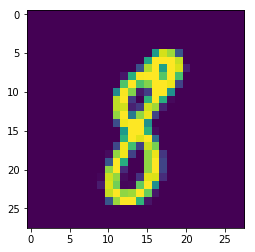

In [93]:
plt.imshow(img.reshape(28,28))
plt.show()

In [94]:
res  = model.predict_classes(img.reshape(1,28,28,1))
print(res)

[8]


In [95]:
layer_1_out = relu(conv2d(layer_1_data,img.reshape(1,28,28)))
layer_1_out = layer_1_out.reshape(26, 26,16)

In [101]:
from keract import get_activations
activations = get_activations(model, img.reshape(1,28,28,1), "layer_1")

In [102]:
layer1 = np.array(activations['layer_1_2/Relu:0'])
layer1 = layer1.reshape(16,26,26)
np.array_equal(layer1,layer_1_out)

False

In [103]:
layer_1_out = layer_1_out.reshape(16,26,26)
layer_1_out[0][3]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01155187,
       0.06121151, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [104]:
layer1 = layer1.reshape(16,26,26)
layer1[0][3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [211]:

val_num_uq = 0
val_num_q = 0
correct_q = np.empty(10000)
correct_uq = np.empty(10000)
val_num_q_2 = 0
correct_q_2 = np.empty(10000)

for i in range(10000):
    indata = x_test[i] /255
    label = y_test[i]
    
    #data = indata.ravel()
    
    keras_res = model.predict_classes(indata.reshape(1,28,28,1))
    res = Model(indata.reshape(1,28,28))
    
    if(label==keras_res[0]):        
        correct_q[val_num_q] = i
        val_num_q += 1

    if(label==np.argmax(res)):
        correct_uq[val_num_uq] = i
        val_num_uq += 1
        
print('val_num_keras_model :', val_num_q)
print('val_num_uq :', val_num_uq)

print('val val_num_keras_model :', (val_num_q/10000)*100,'%')
print('val unquantized  :', (val_num_uq/10000)*100,'%')


(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)

(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)

(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)
(11, 11, 16)
(5, 5, 16)
(26, 26, 16)
(13, 13, 16)
(16, 13, 13)
(16, 11, 11)

In [212]:
img.shape

(28, 28)

In [80]:
channel_im2col(img)

ValueError: not enough values to unpack (expected 3, got 2)

In [68]:

def conv2d(filt,act):
    '''
    conv 2d function
    act = widht, height,depth (w1,h1,d1)
    default = 3,3 filter, stride = 1, p = 0
    im2col reshape
    
    W2=(W1−F+2P)/S+1
    H2=(H1−F+2P)/S+1
    D2=K
    '''
    P = 0
    S = 1
    D1,W1,H1 = act.shape
    n_f,d_f,h_f,w_f = filt.shape
    window_size = d_f*h_f*w_f
    filter_reshape = n_f,window_size
    W2=(W1-h_f +2*P)//S+1
    H2=(H1- h_f+2*P)//S+1
    D2= n_f
    m = channel_im2col(act)
    filt = filt.reshape(filter_reshape)
    res = np.matmul(filt, m)
    res = res.reshape(D2,W2,H2)
    return res
    
def pool2d(conv, kernel_size, stride):

    number_of_images, image_height, image_width, image_depth = conv.shape
    output_height = (image_height - kernel_size) // (stride + 1)
    output_width = (image_width - kernel_size) // (stride + 1)

    pool = np.zeros((number_of_images, output_height, output_width, image_depth))
    for k in range(number_of_images):
        for i in range(output_height):
            for j in range(output_width):
                pool[k, i, j, :] = np.max(conv[k, i*stride:i*stride+kernel_size, j*stride:j*stride+kernel_size, :])
    return pool



import numpy as np
from numpy.lib.stride_tricks import as_strided


    

fil = np.random.randint(2, size=(2,3,3,3)) # number of filter, depth, kernel size(w x h)
A = np.random.randint(5, size=(3,8,8))

In [70]:
fil

array([[[[1, 1, 1],
         [0, 0, 0],
         [0, 0, 0]],

        [[1, 0, 0],
         [1, 1, 1],
         [0, 0, 0]],

        [[1, 1, 0],
         [1, 1, 0],
         [1, 0, 1]]],


       [[[0, 1, 0],
         [1, 0, 0],
         [1, 0, 1]],

        [[1, 1, 1],
         [1, 1, 1],
         [0, 0, 1]],

        [[1, 1, 0],
         [1, 0, 1],
         [0, 0, 1]]]])

In [78]:
relu(A)

array([[[4, 0, 2, 2, 3, 2, 1, 3],
        [3, 0, 2, 4, 2, 2, 0, 0],
        [3, 0, 3, 3, 4, 4, 3, 3],
        [0, 2, 1, 0, 3, 2, 0, 3],
        [1, 1, 0, 4, 2, 1, 0, 4],
        [2, 0, 2, 0, 1, 4, 0, 0],
        [4, 3, 0, 1, 3, 0, 0, 1],
        [4, 4, 4, 4, 3, 3, 2, 0]],

       [[0, 2, 4, 0, 0, 0, 0, 3],
        [0, 3, 1, 3, 1, 4, 2, 4],
        [1, 1, 1, 3, 0, 2, 3, 0],
        [3, 3, 2, 4, 3, 0, 1, 4],
        [3, 1, 2, 1, 0, 1, 2, 3],
        [4, 0, 3, 2, 3, 0, 2, 2],
        [3, 2, 3, 3, 1, 2, 4, 0],
        [4, 2, 1, 3, 0, 2, 4, 1]],

       [[0, 3, 3, 1, 4, 1, 2, 2],
        [2, 3, 3, 1, 0, 3, 0, 3],
        [2, 4, 2, 0, 2, 0, 3, 3],
        [1, 4, 4, 2, 3, 4, 1, 2],
        [1, 0, 2, 2, 4, 3, 0, 1],
        [2, 0, 1, 0, 3, 0, 2, 1],
        [3, 2, 0, 3, 0, 3, 4, 2],
        [1, 2, 3, 0, 4, 0, 4, 3]]])

In [79]:
res = relu(conv2d(fil,A))
res

array([[[22, 29, 28, 21, 26, 25],
        [24, 32, 26, 25, 19, 23],
        [29, 32, 34, 33, 28, 29],
        [21, 20, 23, 22, 30, 20],
        [18, 19, 21, 28, 22, 20],
        [27, 15, 24, 19, 29, 22]],

       [[30, 31, 29, 33, 29, 35],
        [26, 32, 34, 25, 31, 36],
        [27, 39, 32, 33, 26, 33],
        [33, 27, 33, 30, 27, 28],
        [27, 21, 29, 21, 33, 21],
        [36, 35, 27, 31, 39, 24]]])

In [114]:
res

array([[[4, 3, 3, 4],
        [4, 4, 3, 3],
        [3, 2, 4, 4],
        [4, 3, 2, 4]],

       [[4, 4, 3, 4],
        [3, 4, 3, 4],
        [4, 3, 1, 4],
        [4, 3, 4, 4]],

       [[4, 4, 3, 4],
        [2, 3, 3, 1],
        [4, 3, 4, 4],
        [3, 4, 4, 4]]])

In [68]:
res = pool2d2(A.reshape(1,7,7,3),2,2)
res.shape

ValueError: cannot reshape array of size 192 into shape (1,7,7,3)

NameError: name 'img' is not defined

In [96]:
A = np.random.randint(5, size=(3,3))

In [98]:
A

array([[2, 1, 4],
       [0, 1, 2],
       [2, 2, 4]])

In [42]:
layer_1_data.shape

(16, 1, 3, 3)